In [1]:
###Importing some libs to make our lives easier
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.applications.resnet50 import ResNet50
from keras import backend as K
import sys
from numpy import genfromtxt
from keras.utils import to_categorical
from skimage.io import imread
from skimage.color import rgb2gray
from PIL import Image
import skimage
import cv2
import pandas as pd

Using TensorFlow backend.


In [2]:
###import our csv using Pandas(no animals were harmed during this competition)
d = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

In [3]:
###This is a function I used from a super helpful kernel 
###to crop the images to remove the unneccessary black borders.
def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    #img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

In [4]:
###This is a contrast filter to intensify the features of the images and to reduce the image size.
def conv_clah(image_path):

    bgr = cv2.imread(image_path)

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=5.0)

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    lab = circle_crop(lab)
    
    return  rgb2gray(skimage.transform.resize(cv2.cvtColor(lab, cv2.COLOR_LAB2BGR), (224, 224)))

In [5]:
###Make data into matrices from csv
num_classes = 5
images = []
labels = []
ind = 0
for index, row in d.iterrows():
    labels.append(to_categorical(row['diagnosis'], num_classes=num_classes))
    images.append( conv_clah('../input/aptos2019-blindness-detection/train_images/' + row['id_code'] +'.png'))
    ind = ind + 1
    if ind%100==0:
        print(ind)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


In [6]:
###function for getting labels from the one-hot-encoding
def get_label(l, one_hot_size=5):
    ii = np.argmax(l)
    if ii<one_hot_size :
        return ii

(array([1805.,  370.,  999.,  193.,  295.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

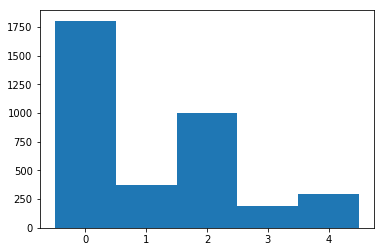

In [7]:
###plot the bar graph of the number of different classes
ll = [get_label(l) for l in labels]
plt.hist(ll, bins=np.arange(min(ll), max(ll)+2), align='left')

In [8]:
###This is a weight dictionary to give more weights to the less frequent classes,
###as there is an imbalanced dataset
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(ll),
                                                 ll)

In [9]:
class_weights

array([0.40576177, 1.97945946, 0.73313313, 3.79481865, 2.48271186])

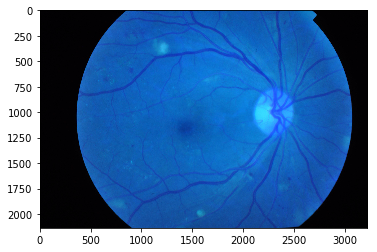

In [10]:
###Original image as given in the dataset.
plt.imshow(cv2.imread('../input/aptos2019-blindness-detection/train_images/4289af3afbd2.png'))

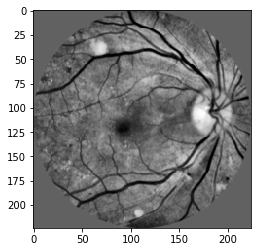

In [11]:
###Above image after all the preprocessing
plt.imshow((conv_clah('../input/aptos2019-blindness-detection/train_images/4289af3afbd2.png')), cmap ='gray')

**if you want oversampling run these cells below, but it didn't give any good results to me so i didnt use em**

In [12]:
###Don't run this cell if you want to reproduce my results.
'''
def get_data(kk, labels=labels, images=images):
    labels1 = []
    images1 = []
    for i, j in zip(labels, images):
        if get_label(i)==kk:
            labels1.append(i)
            images1.append(j)
    return labels1, images1

label_0, images_0 = get_data(0)
label_1, images_1 = get_data(1)
label_2, images_2 = get_data(2)
label_3, images_3 = get_data(3)
label_4, images_4 = get_data(4)

max_size = max(len(label_0),len(label_1),len(label_2),len(label_3),len(label_4))

labels_Y = []
images_X = []
labels_Y = label_0*( max_size//(len(label_0))) + label_1*( max_size//(len(label_1))) + label_2*( max_size//(len(label_2))) + label_3*( max_size//(len(label_3))) + label_4*( max_size//(len(label_4)))
images_X = images_0*( max_size//(len(images_0))) + images_1*( max_size//(len(images_1))) + images_2*( max_size//(len(images_2))) + images_3*( max_size//(len(images_3))) + images_4*( max_size//(len(images_4)))

labels_Y = labels_Y + label_1 + label_2[0:500]
images_X =  images_X + images_1 + images_2[0:500]

ll = [get_label(l) for l in labels_Y]
plt.hist(ll, bins=np.arange(min(ll), max(ll)+3), align='left')
images_X = np.asarray(images_X)
labels_Y = np.asarray(labels_Y)
'''

"\ndef get_data(kk, labels=labels, images=images):\n    labels1 = []\n    images1 = []\n    for i, j in zip(labels, images):\n        if get_label(i)==kk:\n            labels1.append(i)\n            images1.append(j)\n    return labels1, images1\n\nlabel_0, images_0 = get_data(0)\nlabel_1, images_1 = get_data(1)\nlabel_2, images_2 = get_data(2)\nlabel_3, images_3 = get_data(3)\nlabel_4, images_4 = get_data(4)\n\nmax_size = max(len(label_0),len(label_1),len(label_2),len(label_3),len(label_4))\n\nlabels_Y = []\nimages_X = []\nlabels_Y = label_0*( max_size//(len(label_0))) + label_1*( max_size//(len(label_1))) + label_2*( max_size//(len(label_2))) + label_3*( max_size//(len(label_3))) + label_4*( max_size//(len(label_4)))\nimages_X = images_0*( max_size//(len(images_0))) + images_1*( max_size//(len(images_1))) + images_2*( max_size//(len(images_2))) + images_3*( max_size//(len(images_3))) + images_4*( max_size//(len(images_4)))\n\nlabels_Y = labels_Y + label_1 + label_2[0:500]\nimages_X =

In [13]:
###convert gray scale into 3 channels
images = np.asarray([ np.stack((i,)*3, axis=-1) for i in images])
labels = np.asarray(labels)

In [14]:
###Using transfer learning cos I tried to make my own architecture and it didn't work,
####it was overfitting and we need something readily available to us.
def resnet_maker(img_dim, c ,n_class):
    input_tensor=Input(shape=(img_dim, img_dim,c))
  
    model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    model.load_weights('../input/weights-resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    x=GlobalAveragePooling2D()(model.output)
    x=Dropout(0.3)(x)
    x=Dense(1024, activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(512, activation='relu')(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    output =Dense(n_class,activation='softmax', name="Output_Layer")(x)
    model_resnet =Model(input_tensor, output)
    
    return model_resnet
model_resnet=resnet_maker(224,3, 5)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
for layers in model_resnet.layers:
    layers.trainable=True

In [16]:
lr = 1e-3
optimizer=RMSprop(lr=lr,decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])

In [17]:
import gc
gc.collect()

365

In [18]:
d_loss = model_resnet.fit(images,labels, epochs=50, batch_size=8,  validation_split=0.2, shuffle=True, class_weight=class_weights)
print(d_loss)

gc.collect()


Train on 2929 samples, validate on 733 samples
Epoch 1/50
2929/2929 [==============================] - 53s 18ms/step - loss: 0.9570 - acc: 0.6572 - val_loss: 0.6438 - val_acc: 0.7640
Epoch 2/50
2929/2929 [==============================] - 40s 14ms/step - loss: 0.7563 - acc: 0.7221 - val_loss: 0.6104 - val_acc: 0.7681
Epoch 3/50
2929/2929 [==============================] - 40s 14ms/step - loss: 0.7002 - acc: 0.7463 - val_loss: 0.5973 - val_acc: 0.7735
Epoch 4/50
2929/2929 [==============================] - 40s 14ms/step - loss: 0.6989 - acc: 0.7433 - val_loss: 0.5907 - val_acc: 0.7790
Epoch 5/50
2929/2929 [==============================] - 40s 14ms/step - loss: 0.6387 - acc: 0.7665 - val_loss: 0.5845 - val_acc: 0.7817
Epoch 6/50
2929/2929 [==============================] - 40s 14ms/step - loss: 0.6177 - acc: 0.7641 - val_loss: 0.5862 - val_acc: 0.7858
Epoch 7/50
2929/2929 [==============================] - 40s 14ms/step - loss: 0.5907 - acc: 0.7853 - val_loss: 0.5793 - val_acc: 0.7899
E

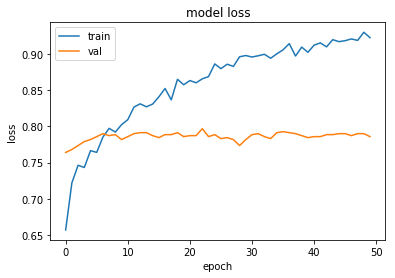

In [19]:
plt.plot(d_loss.history['acc'])
plt.plot(d_loss.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
d = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')


In [21]:
images_test = []
ind = 0
for index, row in d.iterrows():
    images_test.append(conv_clah( '../input/aptos2019-blindness-detection/test_images/'+ row['id_code'] +'.png'))
    ind = ind + 1
    if ind%100==0:
        print(ind)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


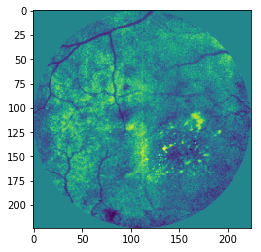

In [22]:
###check123
plt.imshow(images_test[0])

In [23]:
images_test = np.asarray([ np.stack((i,)*3, axis=-1) for i in images_test])

In [24]:
predictions = model_resnet.predict(images_test, batch_size=50, verbose=1)

1928/1928 [==============================] - 7s 4ms/step


In [25]:
pred = []
for i in predictions:
    pred.append(np.argmax(i))

In [26]:
results=pd.DataFrame({"id_code":[ row['id_code'] for index, row in d.iterrows()], "diagnosis":pred})  
results.id_code=results.id_code.apply(lambda x: x[:-4])# results.head()
results.to_csv("submission.csv", index=False)